# Path of destruction

Python script to import Hurricane data and a heuristical model for estimating home damage. We use data for Hurricane Irma from last year in our case study.

---

### Hurricane Irma 
September 8, 2017, 12 Zulu, Created @ ~9AM EST data forecasts

Source: https://www.nhc.noaa.gov/gis/archive_forecast_results.php?id=al11&year=2017&name=Hurricane%20IRMA  
File1: al112017_5day_037.zip (8:59 AM)    
File2: al112017_fcst_037.zip (9:00 AM)

In [1]:
# import packages
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import geojson
from geojson import Feature, FeatureCollection, dump
from shapely.geometry import shape, Point
from geopy.distance import geodesic
import tempfile
import fiona

class Insuricane():
    
####### INITIALIZATION #######
    def __init__(self, name, Point, 
                 base_date = datetime.date(2017, 9, 8)):
        self.name = name
        self.point = Point
        self.date = base_date # base date
        self.path_features = self.__create_path()
        self.cone_features = self.__create_cone()
        self.radius_features = self.__create_radii()
        
        self.generate_kepler_data()
        self.daymap = {0: [0, 1, 2],
                     1: [3, 4, 5],
                     2: [6, 7, 8], 
                     3: [9, 10, 11],
                     4: [12, 13], 
                     5: [14, 15]}
    
    def get_day_num(self, day):
        return min(5, (day - self.date).days)

####### GENERATING GEOJSON DATA #######
    # path of hurricane
    def __create_path(self):
        HURRICANE_PATH = './al112017_5day_037/al112017-037_5day_lin.shp'
        path = fiona.open(HURRICANE_PATH)
        first_path = next(iter(path))
        path_features = [Feature(geometry = first_path['geometry'], properties = {"hurricane": "Irma"})]

        # add more features...
        for i in range(0, 6):
            point = Point(first_path['geometry']['coordinates'][i])
            day = str(datetime.date(2017, 9, 8) + datetime.timedelta(i))
            # 5d predictions
            path_features.append(Feature(geometry = point, properties = {"day": day}))
        return path_features

    # hurricane cone
    def __create_cone(self):
        HURRICANE_ERROR_CONE = './al112017_5day_037/al112017-037_5day_pgn.shp'
        cone = fiona.open(HURRICANE_ERROR_CONE)
        first_cone = next(iter(cone))
        cone_features = [Feature(geometry = first_cone['geometry'], properties={"shape": "Prediction"})]
        return cone_features

    # hurricane wind radii
    def __create_radii(self):
        HURRICANE_WIND_RADII = './al112017_fcst_037/al112017_2017090809_forecastradii.shp'
        radius = fiona.open(HURRICANE_WIND_RADII)
        radius_features = []
        for i in range(len(radius)):
            rad_num = radius[i]
            radius_features.append(Feature(geometry = rad_num['geometry'], properties = {"shape": "Wind speed"})) 

        return radius_features

    # dump data for Kepler
    def generate_kepler_data(self):
        with open('./geojson/path.geojson', 'w') as f:
            dump(FeatureCollection(self.path_features), f)

        with open('./geojson/cone.geojson', 'w') as f:
            dump(FeatureCollection(self.cone_features), f)

        with open('./geojson/radii.geojson', 'w') as f:
            dump(FeatureCollection(self.radius_features), f)
    
####### CALCULATING LOCATIONS AND FEATURES #######
    # which radii is it in for wind?
    def find_in_radius(self, day, suppressPrint = False):
        found = []
        counter = 0
        radius_subset = self.daymap[self.get_day_num(day)]
        for i in radius_subset:
            counter = counter + 1
            polygon = shape(self.radius_features[i].geometry)

            if(polygon.contains(self.point)):
                point_num = 1 if (counter == 0) else (-1 if (counter == len(radius_subset) - 1) else 0)
                point_name = 'fastest' if (counter == 0) else ('slowest' if (counter == len(radius_subset) - 1) else 'middle')

                if (suppressPrint == False):
                    print('Found your location on day {} at {} wind radius'.format(
                        self.get_day_num(day), point_name))
                found = found + [point_num] # days separate
        return found

    # closest radii
    def find_distance_circle(self, day):
        point_coord = (self.point.coords.xy[0][0], self.point.coords.xy[1][0])
        found = {}
        counter = 0
        radius_subset = self.daymap[self.get_day_num(day)]
        for i in radius_subset:
            counter = counter + 1
            polygon = shape(self.radius_features[i].geometry)            
            point_num = 1 if (counter == 0) else (-1 if (counter == len(radius_subset) - 1) else 0)

            if(polygon.contains(self.point)):
                found[point_num] = '' # don't include ones we're in
            else:
                found[point_num] = min([geodesic(point_coord, j).miles for j in polygon.exterior.coords])
        return found
    
    # distance to the eye on a given day
    def find_distance_eye(self, day):
        point_coord = (self.point.coords.xy[0][0], self.point.coords.xy[1][0])
        return geodesic(point_coord, 
                        tuple(self.path_features[self.get_day_num(day) + 1]['geometry']['coordinates'])).miles
    
    
    ### We want this to be able to change per day. We have the eye by day, we have radii by day.
    # radius weighting
    def __calc_radius_weight(self, day, **kwargs):
        radius_found = self.find_in_radius(day, **kwargs)
        try:
            radius_weight = 0.35 + float(max(radius_found) * 0.1) # 0.45, 0.35, 0.25
        except: # none were found - outside all of the radii
            radius_weight = 0
        return radius_weight

    # loop weighting
    def __calc_circle_weight(self, day, **kwargs):
        radius_found = self.find_in_radius(day, **kwargs)
        dist = self.find_distance_circle(day)
        try:
            if (max(radius_found) == 1):
                radii_distance_weight = 0.2
            else:
                radii_distance_weight = (1 - dist[max(radius_found) + 1]/100) * (0.1 + 0.05 * max(radius_found))
        except: # none were found - outside all of the radii
            try:
                radii_distance_weight = (1 - dist[-1]/100) * 0.05
            except:
                radii_distance_weight = 0.025
        return radii_distance_weight

    
####### ACTUAL-VALUED HEURISTICAL MODEL #######
    # chance your house is destroyed
    def __calc_chance_hurricane(self, day, **kwargs):
        distance_weight = (1 - self.find_distance_eye(day)/1000) * 0.35
        return (
            max(distance_weight, 0) + 
            max(self.__calc_radius_weight(day, **kwargs), 0) + 
            max(self.__calc_circle_weight(day, **kwargs), 0))
    
    # does this for each of the 5 days
    def calc_risk(self, **kwargs):
        hurrichance = {}
        for i in range(7):
            second_day = self.date + datetime.timedelta(i) # increment days
            hurrichance[second_day] = self.__calc_chance_hurricane(second_day, **kwargs)
        hurrichance = pd.DataFrame(hurrichance, index = ['chance']).T
        return hurrichance.applymap(lambda x: 0 if (x < 0) else x)
    
    # maximum chance of a hurricane
    def calc_max_hurricane(self):
        hurricane_a1 = self.calc_risk(suppressPrint = True) # never print for this
        hurricane_a1 = hurricane_a1[hurricane_a1.index != min(hurricane_a1.index)]
        hurricane_temp = hurricane_a1[hurricane_a1['chance'] == max(hurricane_a1['chance'])]
        return (hurricane_temp['chance'])

####### PLOT CHANCE OF HITTING #######
    # plot hurricane chance
    def plot_irmachance(self, alpha = 0.5):
        hurricane_ts = self.calc_risk(suppressPrint = True)

        hurricane_df = hurricane_ts[datetime.date(2017, 9, 9):].copy()
        hurricane_df['ewm'] = hurricane_df.ewm(alpha).mean()
        hurricane_df = hurricane_df.applymap(lambda x: 100 * x)

        sns.set(font_scale = 1.1)
        sns.set_style('whitegrid')
        plt.figure(figsize = (8, 6))
        plt.plot(hurricane_df['chance'], marker = 'o', color = '#4285f4', alpha = 0.75, label = 'Chance of hurricane')
        plt.plot(hurricane_df['ewm'], linestyle = '--', color = '#DC143C', alpha = 0.5, label = 'Rolling likelihood')
        plt.xticks(rotation = -15)
        plt.xlabel('Date')
        plt.ylabel('Chance of hurricane')
        plt.title('Chance of {} homes destroyed'.format(self.name))

        plt.plot(self.calc_max_hurricane().index.values[0], 
                 self.calc_max_hurricane().values[0] * 100, 
                 color = '#4285f4', marker = 's', linestyle = 'none', label='Riskiest day')

        plt.legend()
        plt.show()

Testing for Disney World

In [2]:
# initialize
BCG = Insuricane('Disney', Point((-81.38144, 28.54434)))

In [3]:
# chance of hurricane
BCG.calc_risk(suppressPrint = True)

,chance
2017-09-08,0.162809
2017-09-09,0.208797
2017-09-10,0.259316
2017-09-11,0.318054
2017-09-12,0.366242
2017-09-13,0.721513
2017-09-14,0.721513


In [4]:
# most dangerous day
BCG.calc_max_hurricane() 

2017-09-13    0.721513
2017-09-14    0.721513
Name: chance, dtype: float64

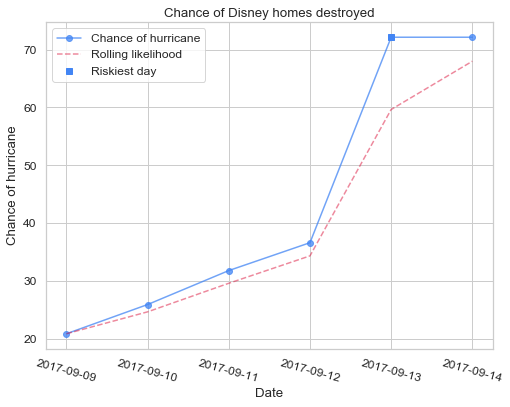

In [5]:
# plot graph
BCG.plot_irmachance()